In [3]:
from utilities import DGLGraph_plotter, load_dgl_graphs_from_bin, prune_graphs
import networkx as nx
import dgl

In [ ]:
dgl_train_graphs, t_ids = load_dgl_graphs_from_bin('dgl/train_dgl_graphs.bin', 'dgl/train_patient_ids.pkl')
dgl_validation_graphs, v_ids = load_dgl_graphs_from_bin('dgl/val_dgl_graphs.bin', 'dgl/val_patient_ids.pkl')
dgl_test_graphs, test_ids = load_dgl_graphs_from_bin('dgl/test_dgl_graphs.bin', 'dgl/test_patient_ids.pkl')

In [ ]:
def dgl_to_simple_graph(dgl_graph):
    nx_multigraph = dgl_graph.to_networkx().to_undirected()
    nx_graph = nx.Graph()
    
    # Copy node attributes
    for node, attrs in dgl_graph.ndata.items():
        for u, attr_values in enumerate(attrs):
            if node == 'label':
                attr_values = int(attr_values)
            elif node == 'feat':
                attr_values = attr_values.tolist()
            nx_graph.add_node(u, **{node: attr_values})
    
    # Copy edges (while removing multiple edges)
    for u, v, data in nx_multigraph.edges(data=True):
        if nx_graph.has_edge(u, v):
            continue
        nx_graph.add_edge(u, v, **data)
    
    return nx_graph


In [ ]:
nx_graph = dgl_to_simple_graph(graph)

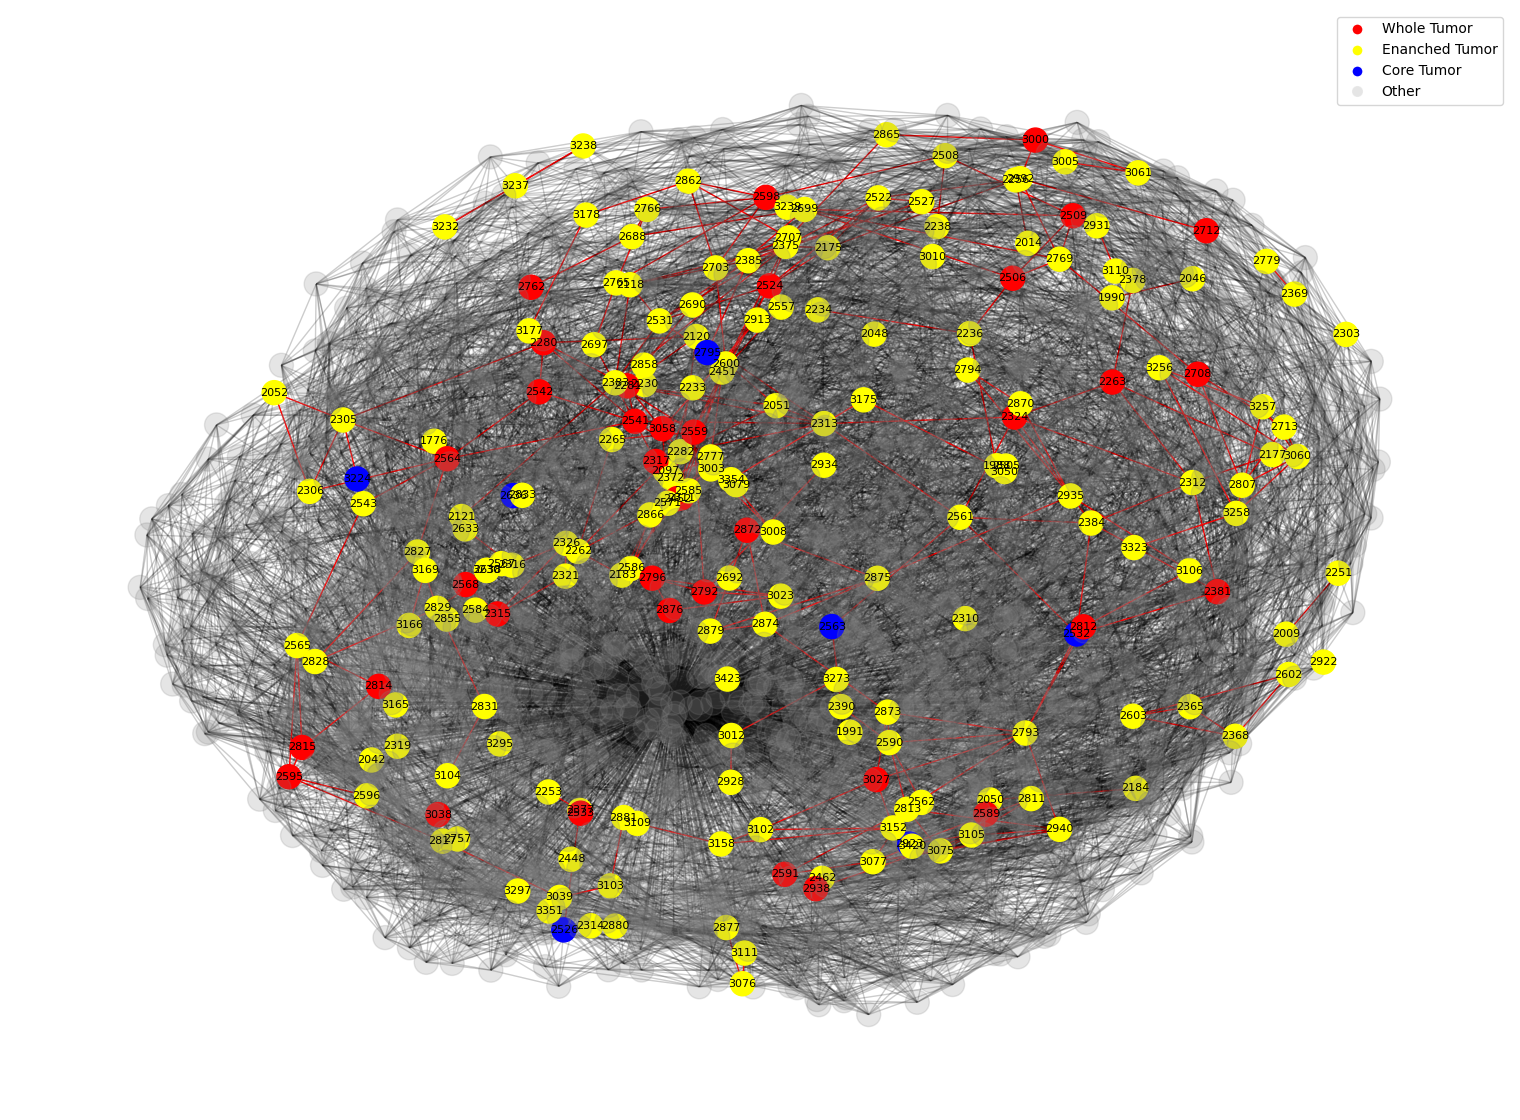

In [ ]:
DGLGraph_plotter(nx_graph)

In [3]:
import numpy as np
import nibabel as  nib
from utilities import _3Dplotter

In [4]:
images_file = ['../patient/BraTS2021_00025_flair.nii.gz', '../patient/BraTS2021_00025_t1.nii.gz',
               '../patient/BraTS2021_00025_t1ce.nii.gz', '../patient/BraTS2021_00025_t2.nii.gz']

In [25]:
flair_ex = nib.load(images_file[0])
# Visualize the image with _3Dplotter()
np.max(flair_ex.get_fdata())

5.1335050231981425

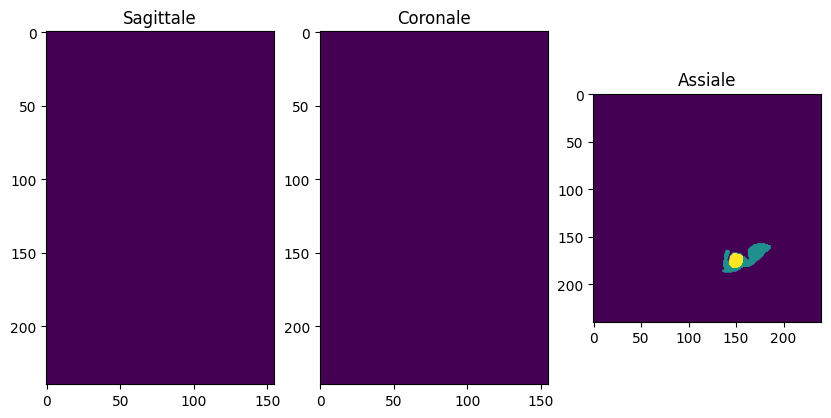

In [9]:
seg = nib.load('..\patient\BraTS2021_00025_seg.nii.gz').get_fdata()
_3Dplotter(seg)

In [4]:
def pick_image(id, dataset_path='../raw_dataset'):
    flair = nib.load(f"{dataset_path}/BraTS2021_{id}/BraTS2021_{id}_flair.nii.gz")
    t1 = nib.load(f"{dataset_path}/BraTS2021_{id}/BraTS2021_{id}_t1.nii.gz")
    t2 = nib.load(f"{dataset_path}/BraTS2021_{id}/BraTS2021_{id}_t2.nii.gz")
    t1ce = nib.load(f"{dataset_path}/BraTS2021_{id}/BraTS2021_{id}_t1ce.nii.gz")
    seg = nib.load(f"{dataset_path}/BraTS2021_{id}/BraTS2021_{id}_seg.nii.gz")
    return flair, t1, t2, t1ce, seg

In [5]:
flair, t1, t2, t1ce, seg = pick_image('00025')

In [6]:
print(np.max(flair.get_fdata()))

2771.0


In [7]:
def rescale_normalize_nii_image(image, save=False):
    # Get the image data as a NumPy array
    img_data = image.get_fdata()
    # Calculate the 99.5th percentile value
    percentile_99_5 = np.percentile(img_data, 99.5)
    # Rescale intensities by dividing them by the 99.5th percentile value
    img_data_rescaled = img_data / percentile_99_5
    # Clip the values to the range [0, 1]
    img_data_rescaled = np.clip(img_data_rescaled, 0, 1)
    # Create a new NIfTI image with the rescaled data
    mean = np.mean(img_data_rescaled)
    std_dev = np.std(img_data_rescaled)
    img_data_normalized = (img_data_rescaled - mean) / std_dev
    # Create a new NIfTI image with the rescaled and normalized data
    normalized_img = nib.Nifti1Image(img_data_normalized, image.affine)
    return normalized_img

In [8]:
rescaled_normalize_flair = rescale_normalize_nii_image(flair)
print(np.max(rescaled_normalize_flair.get_fdata()))

3.496207209060346


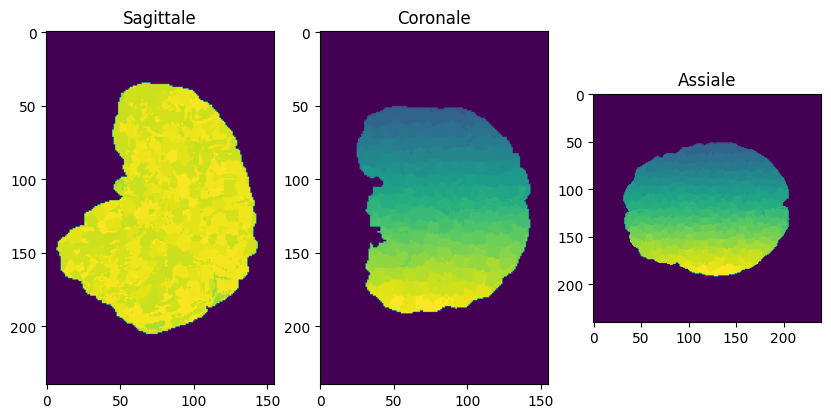

[    0.  3132.  3133. ... 12311. 12314. 12768.]


In [22]:
SLIC = nib.load('..\old_dataset\BraTS2021_00025\BraTS2021_00025_SLIC.nii.gz').get_fdata()
_3Dplotter(SLIC)
print(np.unique(SLIC))

In [104]:
import numpy as np

def compute_supervoxel_percentile(SLIC, scan):
    supervoxel_percentile = {}
    
    unique_labels = np.unique(SLIC)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude the zero label

    # Create a mask that contains only the unique labels in SLIC
    mask = np.isin(SLIC, unique_labels)

    # Use the mask to extract the intensities for each label from the scan
    intensities = [scan[mask & (SLIC == label)] for label in unique_labels]

    # Compute the percentile for each set of intensities
    supervoxel_percentile = {int(label): [np.percentile(values, 10), np.percentile(values, 25), np.percentile(values, 50), np.percentile(values, 75), np.percentile(values, 90)] for label, values in zip(unique_labels, intensities)}

    return supervoxel_percentile


In [105]:
compute_supervoxel_percentile(SLIC, rescaled_normalize_flair.get_fdata())

{3132: [-0.04571831947668813,
  -0.03721381043263623,
  0.11870218870831481,
  0.28676748648362577,
  0.43012921036907176],
 3133: [0.1743864741157974,
  0.3135971876345037,
  0.8871453273315737,
  1.7669570367697978,
  2.4649342433137695],
 3144: [-0.14635500983130198,
  -0.07366170633571571,
  0.4457208102831668,
  0.9802899501949991,
  1.4460130645121256],
 3146: [0.5518246850232427,
  0.6092301210705929,
  0.7423661852721193,
  0.9013195090716603,
  1.0051960123954369],
 3366: [0.709968055580493,
  0.8491787690991993,
  1.3052836886641244,
  1.6657128814834659,
  1.8337781792587768],
 3368: [0.09035382522814195,
  0.20982192846601352,
  0.7646398994351121,
  1.1493676895231735,
  1.4648444773953835],
 3369: [-0.0894557945603835,
  0.14097590287130785,
  0.3090412006466188,
  0.5236788098536423,
  0.8136420705936968],
 3370: [0.1996975129373803,
  0.2088094869131502,
  0.2432324997105031,
  0.30144788900014385,
  0.5783506537082614],
 3371: [0.29182969424794236,
  0.3864929794406626

In [5]:
import os

def compute_supervoxel_percentile(SLIC, *scans):
    supervoxel_percentile = {}
    
    unique_labels = np.unique(SLIC)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude the zero label

    # Create a mask that contains only the unique labels in SLIC
    mask = np.isin(SLIC, unique_labels)

    # Loop over each scan
    for scan in scans:
        # Use the mask to extract the intensities for each label from the scan
        intensities = [scan[mask & (SLIC == label)] for label in unique_labels]

        # Compute the percentile for each set of intensities
        scan_percentiles = {int(label): [np.percentile(values, 10), np.percentile(values, 25), np.percentile(values, 50), np.percentile(values, 75), np.percentile(values, 90)] for label, values in zip(unique_labels, intensities)}
        
        # If the label is already in the dictionary, concatenate the percentiles. If not, add it to the dictionary.
        for label, percentiles in scan_percentiles.items():
            if label in supervoxel_percentile:
                supervoxel_percentile[label].extend(percentiles)
            else:
                supervoxel_percentile[label] = percentiles

    return supervoxel_percentile


def crop_nii(image_data, img):
    target_shape = (240, 240, 155)
    # Get the original shape of the image data
    original_shape = image_data.shape
    # Calculate the start and end indices for each dimension
    start_indices = tuple((original_shape[i] - target_shape[i]) // 2 for i in range(3))
    end_indices = tuple(start_indices[i] + target_shape[i] for i in range(3))
    # Crop the image data using NumPy slicing
    cropped_image_data = image_data[
        start_indices[0]:end_indices[0],
        start_indices[1]:end_indices[1],
        start_indices[2]:end_indices[2]
    ]    
    # Use the original image's affine transformation matrix
    affine = img.affine
    # Create a new Nifti1Image object with the cropped image data
    cropped_nifti_image = nib.Nifti1Image(cropped_image_data, affine)
    return cropped_nifti_image


def preprocess(brain_images_path):
    print('starting preprocessing...')
    subdirectories = [d for d in os.listdir(brain_images_path) if os.path.isdir(os.path.join(brain_images_path, d))]
    for subdir in subdirectories:
        subdir_path = os.path.join(brain_images_path, subdir)
        print(subdir)
        os.makedirs(f'../preprocessed_dataset/{subdir}')
        for filename in os.listdir(subdir_path):
            try:
                scan_modality = (filename.split("_")[2]).split(".")[0]
                if scan_modality in ['flair','t1','t2','t1ce']:
                    scan = nib.load(f"{brain_images_path}/{subdir}/{filename}")
                    preprocessed_image = rescale_normalize_nii_image(scan)
                    cropped_scan = crop_nii(preprocessed_image.get_fdata(), scan)
                    nib.save(cropped_scan, f"../preprocessed_dataset/{subdir}/{filename}")
                    print(f"{filename} correctly preprocessed")
            except:
                raise Exception(f"{filename} is not a valid file for processing")
                #print(f"{filename} is not a valid file for processing")

In [8]:
import pickle
import nibabel as nib
import numpy as np
import os

def get_patient_ids(paths):
    ids = []
    for path in paths:
        splitted_path = path.split("/")
        ids.append(splitted_path[-1].split("_")[1])
    if all(elem == ids[0] for elem in ids):
        return ids, True
    else:
        return ids, False

def generate_features(old_dataset, new_dataset, features_path):

    list_feature_completed = []
    features_completed = [d for d in os.listdir(features_path)]
    for f in features_completed:
        id_f = f.split('_')[1].split('.')[0]
        list_feature_completed.append(id_f)

    i = 1
    subdirectories = [d for d in os.listdir(old_dataset) if os.path.isdir(os.path.join(old_dataset, d))]
    for subdir in subdirectories:
        if not subdir == 'features':
            subdir_path = os.path.join(old_dataset, subdir)
            scans = []
            id, flag = get_patient_ids([f"{old_dataset}{subdir}"])
            i = i + 1
            if id[0] not in list_feature_completed:
                print(f"Processing {id[0]}: slic taken from {old_dataset} | flair, t1, t2, t1ce from {new_dataset}")
                for filename in os.listdir(subdir_path):
                    try:
                        substring = filename.split("_")[2]
                        modality = substring.split(".")[0]
                        if modality in ['SLIC']:
                            slic = nib.load(f"{old_dataset}{subdir}/{filename}")
                        elif modality in ['flair','t1','t2','t1ce']:
                            scans.append(nib.load(f"{new_dataset}{subdir}/{filename}").get_fdata())
                    except:
                        pass

                features = compute_supervoxel_percentile(slic.get_fdata(), scans[0], scans[1], scans[2], scans[3])

                with open(f"{features_path}features_{id[0]}.pkl", "wb") as f:
                    pickle.dump(features, f)

In [9]:
generate_features('../old_dataset/', '../preprocessed_dataset/', '../new_features/')

Processing 00059: slic taken from ../old_dataset/ | flair, t1, t2, t1ce from ../preprocessed_dataset/
Processing 00072: slic taken from ../old_dataset/ | flair, t1, t2, t1ce from ../preprocessed_dataset/
Processing 00089: slic taken from ../old_dataset/ | flair, t1, t2, t1ce from ../preprocessed_dataset/
Processing 00132: slic taken from ../old_dataset/ | flair, t1, t2, t1ce from ../preprocessed_dataset/
Processing 00167: slic taken from ../old_dataset/ | flair, t1, t2, t1ce from ../preprocessed_dataset/
